In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


In [52]:
import autoencoder.aecExtraFeatures as Z_calculations


def addZToPrediction(model, data_point):
    encoded = model.encoder(data_point)
    reconstruction = model.decoder(encoded)

    Z_features = [Z_calculations.getZVector(
        data_point, reconstruction, encoded)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point


In [53]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(
        model_1(data_point), data_point), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)


In [54]:
from turtleIsolationForests.preprocessFeatures import preprocess_features
from turtleIsolationForests.preprocessFeatures import preprocess_features_autoEncoder

train_dataframe_autoencoder = pd.read_csv(
    "eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe_autoencoder = pd.read_csv(
    "eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_dataframe_Trees = train_dataframe_autoencoder.copy(deep=True)
test_dataframe_Trees= test_dataframe_autoencoder.copy(deep=True)

train_data, test_data, train_labels, test_labels = preprocess_features_autoEncoder(
    train_dataframe_autoencoder, test_dataframe_autoencoder)


In [55]:
# this point 0 is normal and 1 is abnormal
# first four should be False, False, True, False
train_labels


array([False, False,  True, ..., False,  True, False])

In [56]:
auto_train_labels = ~train_labels
auto_test_labels = ~test_labels


In [57]:


normal_train_data = train_data[auto_train_labels]
normal_test_data = test_data[auto_test_labels]

anomalous_train_data = train_data[~auto_train_labels]
anomalous_test_data = test_data[~auto_test_labels]


In [58]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector(46)


In [59]:
autoencoder.compile(optimizer='adam', loss='mae')


In [60]:
normal_train_data.shape


TensorShape([67343, 46])

In [61]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=10000,
                          validation_data=(test_data, test_data),
                          shuffle=True)


Epoch 1/10000
2105/2105 [==============================] - 6s 2ms/step - loss: 0.0175 - val_loss: 0.0012
Epoch 2/10000
2105/2105 [==============================] - 4s 2ms/step - loss: 6.2275e-04 - val_loss: 6.8704e-04
Epoch 3/10000
2105/2105 [==============================] - 4s 2ms/step - loss: 4.4622e-04 - val_loss: 6.5683e-04
Epoch 4/10000
2105/2105 [==============================] - 4s 2ms/step - loss: 3.2652e-04 - val_loss: 4.0607e-04
Epoch 5/10000
2105/2105 [==============================] - 5s 2ms/step - loss: 2.0828e-04 - val_loss: 4.0008e-04
Epoch 6/10000
2105/2105 [==============================] - 5s 2ms/step - loss: 1.9940e-04 - val_loss: 3.8005e-04
Epoch 7/10000
2105/2105 [==============================] - 5s 2ms/step - loss: 1.8777e-04 - val_loss: 3.7953e-04
Epoch 8/10000
2105/2105 [==============================] - 5s 3ms/step - loss: 1.8197e-04 - val_loss: 3.6946e-04
Epoch 9/10000
2105/2105 [==============================] - 5s 3ms/step - loss: 1.8043e-04 - val_loss: 3.

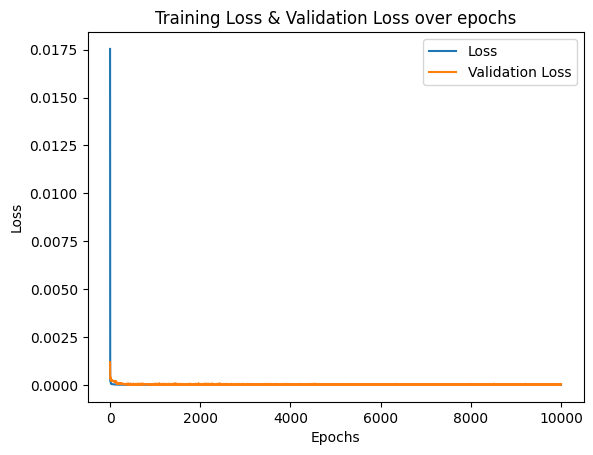

In [62]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()


In [63]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


2105/2105 [==============================] - 2s 989us/step
Threshold:  0.00020222427260154654


In [64]:
import time


def predict(model, data, threshold):
    # start = time.time_ns()
    reconstructions = model(data)
    # end = time.time_ns()
    # print("Time taken", end-start, "ns")

    # 0 = anomaly (same as data)
    loss = tf.keras.losses.mae(data, reconstructions)
    return tf.math.less(loss, threshold)


def getLoss(model, data):
    reconstructions = model(data)
    # 0 = anomaly (same as data)
    loss = tf.keras.losses.mae(data, reconstructions)
    return loss


def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("F1 = {}".format(f1_score(labels, predictions)))
    print("roc_auc = {}".format(roc_auc_score(labels, predictions)))


In [65]:
%% timeit
%% capture

predict(autoencoder, test_data, threshold)


UsageError: Line magic function `%` not found.


In [66]:
%%capture

test_predictions = predict(autoencoder, test_data, threshold)


In [67]:
print_stats(test_predictions, test_labels)


Accuracy = 0.5637863733144074
Precision = 0.5669628901888983
Recall = 0.9893243980363127
F1 = 0.7208312042241526
roc_auc = 0.4953830310642896


In [68]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, test_predictions))


[[   14  9697]
 [  137 12696]]


In [69]:

from pandas import DataFrame
from turtleIsolationForests.printResults import print_results
from turtleIsolationForests.printResults import get_auroc_value

test_predictions_np = test_predictions.numpy()

autoec_predictions = DataFrame()

# 0: anomalous, 1: normal
autoec_predictions['predicted_as_anomaly'] = ~test_predictions_np
autoec_predictions['is_anomalous'] = auto_test_labels  # 0: normal, 1: anomalous
autoec_predictions['anomaly_scores'] = getLoss(autoencoder, test_data)

print_results(test_predictions_np, test_labels)
print("auroc: " + str(get_auroc_value(test_predictions_np, auto_test_labels)))


true anomalies: 12696
false anomalies: 9697
false normals: 137
true normals: 14
precision: 0.5669628901888983
recall: 0.9893243980363127
f1-score: 0.7208312042241526
auroc: 0.5046169689357104


In [70]:
# 1: normal, 0: anomalous
test_predictions_np

array([ True,  True,  True, ...,  True,  True,  True])

In [71]:
# 1: normal, 0: anomalous
test_labels

array([ True,  True, False, ...,  True, False,  True])

In [72]:
train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe_Trees, test_dataframe_Trees)

In [73]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [74]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [75]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(
            np_train_data[:][:][i].numpy().reshape(1, 46).squeeze())

    return pd.DataFrame(data_with_Z_rf)


In [76]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

# anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)


In [77]:
# train_data_with_Z_df


In [78]:
np_test_labels = np.array(np_test_labels)


In [79]:
#np_test_labels = ~np_test_labels

In [80]:
#Should be anomley is true so opisite of aoutencoder
predicted_anomalous = np_test_data[~test_predictions.numpy()]


In [81]:
train_data_with_Z_df


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
125969,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
125970,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387
125971,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387


In [82]:
predicted_anomalous_labels = np_test_labels[~test_predictions.numpy()]


In [83]:
predicted_anomalous_labels


array([ True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [84]:
anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)


In [85]:
contamination = sum(train_labels == 0) / len(train_labels)


In [86]:
anomalous_test_data_with_Z_df


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-1.035688,-1.161030,4.854138,2.756092,-0.289103,1.608759,1.618955,-0.387635,-0.376387
147,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-1.523589,0.120567,1.066401,-0.439078,-0.383108,-0.111426,-0.639532,-0.624871,-0.387635,-0.376387
148,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-1.775591,-0.809857,1.066401,-0.439078,2.756092,1.398835,-0.639532,-0.624871,-0.387635,-0.376387
149,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,0.734343,-0.466594,-0.604172,-0.333214,-0.447834,-0.289103,1.608759,1.618955,-0.387635,-0.376387


In [87]:
def getFinalPredictions(first_predictions, second_predictions):
    autoencoder_copy = first_predictions.copy()
    if_copy = second_predictions.copy()
    indices = autoencoder_copy.index[autoencoder_copy["predicted_as_anomaly"] == True]
    if_copy.index = indices
    autoencoder_copy.loc[indices,
                         "predicted_as_anomaly"] = if_copy["predicted_as_anomaly"]
    print_results(autoencoder_copy)
    print("auroc: " + str(get_auroc_value(second_predictions)))


In [88]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results

eif = ExtendedIsolationForest(contamination=contamination, random_state=None)
eif.fit(train_data_with_Z_df, train_labels)


In [89]:
%% timeit

eif.predict(anomalous_test_data_with_Z_df)


UsageError: Cell magic `%%` not found.


In [90]:
type(predicted_anomalous_labels)


numpy.ndarray

In [91]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df, predicted_anomalous_labels)
print(type(eif_predictions))
eif_predictions['is_anomalous'] = predicted_anomalous_labels

# print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)


<class 'tuple'>


TypeError: 'tuple' object does not support item assignment

In [ ]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df, predicted_anomalous_labels)
eif_predictions['is_anomalous'] = predicted_anomalous_labels

# print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)


true anomalies: 2009
false anomalies: 2392
false normals: 5151
true normals: 4309
precision: 0.45648716200863443
recall: 0.28058659217877097
f1-score: 0.34754778998356545


In [ ]:

train_predictions = eif.train_scores
train_predictions['is_anomalous'] = train_labels
print_results(train_predictions)


In [ ]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination=contamination,
                         num_hyperplanes_per_split=5, random_state=None)
scif.fit(train_data_with_Z_df, train_labels)


In [ ]:
%% timeit

scif.predict(anomalous_test_data_with_Z_df)


In [ ]:
scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_anomalous'] = predicted_anomalous_labels

# print_results(scif_predictions)
getFinalPredictions(autoec_predictions, scif_predictions)


In [ ]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination=contamination, random_state=None)
isoforest.fit(train_data_with_Z_df, train_labels)


In [ ]:
% % timeit

isoforest.predict(anomalous_test_data_with_Z_df)


In [ ]:
isoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_anomalous'] = predicted_anomalous_labels

# print_results(isoforest_predictions)
getFinalPredictions(autoec_predictions, isoforest_predictions)


In [ ]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination=contamination, random_state=None)
fbif.fit(train_data_with_Z_df, train_labels)


In [ ]:
% % timeit

fbif.predict(anomalous_test_data_with_Z_df)


In [ ]:
fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_anomalous'] = predicted_anomalous_labels

# print_results(fbif_predictions)
getFinalPredictions(autoec_predictions, fbif_predictions)
